In [1]:
import os
import importlib.util

import matplotlib
# matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt

import numpy as np
import h5py
import tensorflow as tf
import pickle

from alad_mod.alad import ALAD
from evaluation.histogram_builder import *
from data.hlf_preprocessing import load

In [2]:
result_path = '/home/oliverkn/pro/alad_6021/2_l16'
model_file = 'model-10000000'

# result_path = '/home/oliverkn/euler/results/opendata_v2/b_mix_pre/b_0'
# model_file = 'model-3500000'

print('loading alad')

# loading config
spec = importlib.util.spec_from_file_location('config', os.path.join(result_path, 'config.py'))
config_alad = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config_alad)

# loading preprocessor
preprocessor = load(os.path.join(result_path, 'preprocessor.pkl'))

# loading alad
tf.reset_default_graph()
ad = ALAD(config_alad, tf.Session())
ad.load(os.path.join(result_path, model_file))

loading alad


W1118 21:06:33.971866 139907273148224 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W1118 21:06:34.016448 139907273148224 deprecation_wrapper.py:119] From /home/oliverkn/cloud/eth/2019_FS/pro/pycharm/alad_mod/alad.py:29: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1118 21:06:34.019674 139907273148224 deprecation_wrapper.py:119] From /home/oliverkn/cloud/eth/2019_FS/pro/pycharm/alad_mod/alad.py:44: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W1118 21:06:34.020720 139907273148224 deprecation.py:323] From /home/oliverkn/pro/alad_6021/2_l16/config.py:81: dense (from tens

In [3]:
lum = 4429

W_proc_list = ['w1jets', 'w2jets', 'w3jets']
DY_proc_list = ['dy1jets', 'dy2jets', 'dy3jets', 'dy4jets']
ttbar_proc_list = ['ttbar']
data_proc_list = ['data']
b_proc_list = W_proc_list + DY_proc_list
bs_proc_list = b_proc_list + ttbar_proc_list
proc_list = bs_proc_list + data_proc_list

sets = {}
sets['dy1jets'] = {'file': '/home/oliverkn/pro/opendata_v2/7719/data_pre.hdf5', 'xsec':561, 'K':1.23}
sets['dy2jets'] = {'file': '/home/oliverkn/pro/opendata_v2/7721/data_pre.hdf5', 'xsec':181, 'K':1.23}
sets['dy3jets'] = {'file': '/home/oliverkn/pro/opendata_v2/7722/data_pre.hdf5', 'xsec':51, 'K':1.23}
sets['dy4jets'] = {'file': '/home/oliverkn/pro/opendata_v2/7723/data_pre.hdf5', 'xsec':15, 'K':1.23}

sets['w1jets'] = {'file': '/home/oliverkn/pro/opendata_v2/9863/data_pre.hdf5', 'xsec':4480, 'K':1.23}
sets['w2jets'] = {'file': '/home/oliverkn/pro/opendata_v2/9864/data_pre.hdf5', 'xsec':1435, 'K':1.23}
sets['w3jets'] = {'file': '/home/oliverkn/pro/opendata_v2/9865/data_pre.hdf5', 'xsec':304, 'K':1.23}

sets['ttbar'] = {'file': '/home/oliverkn/pro/opendata_v2/9588/data_pre.hdf5', 'xsec':164, 'K':1.66}
sets['data'] = {'file': '/home/oliverkn/pro/opendata_v2/6021/data_pre.hdf5', 'xsec':1, 'K':1}


# lum = 4429
# 
# W_proc_list = ['W+', 'W-']
# DY_proc_list = ['DYtoll']
# ttbar_proc_list = ['ttbar']
# data_proc_list = ['data']
# b_proc_list = W_proc_list + DY_proc_list
# bs_proc_list = b_proc_list + ttbar_proc_list
# proc_list = bs_proc_list + data_proc_list
# 
# sets = {}
# sets['DYtoll'] = {'file': '/home/oliverkn/pro/opendata_v2/7730/data.hdf5', 'xsec':1141, 'K':1}
# sets['W-'] = {'file': '/home/oliverkn/pro/opendata_v2/9938/data.hdf5', 'xsec':5090, 'K':1}
# sets['W+'] = {'file': '/home/oliverkn/pro/opendata_v2/9940/data.hdf5', 'xsec':7110, 'K':1}
# sets['ttbar'] = {'file': '/home/oliverkn/pro/opendata_v2/9588/data.hdf5', 'xsec':164, 'K':1.66}
# 
# sets['data'] = {'file': '/home/oliverkn/pro/opendata_v2/6021/data.hdf5', 'xsec':1, 'K':1}

In [4]:
data_dict = {}

def pre_select(x):
    filter_iso = x[:,7] + x[:,8] + x[:,9] < 0.1
    filter_eta = np.abs(x[:,5]) < 1.4
    # filter_eta2 = np.logical_or(np.abs(x[:,5]) < 1.44, np.abs(x[:,5]) > 1.56)
    filter_njets = x[:,2] > 1
    # filter_idx = filter_njets * filter_eta * filter_iso #* filter_eta2
    filter_idx = filter_iso * filter_eta * filter_njets
    
    return x[filter_idx]

for key, set in sets.items():
    print('-----------------loading %s-----------------' % key)

    file = set['file']
    hdf5_file = h5py.File(file, 'r')
    
    data = hdf5_file['data']
    n_tot = hdf5_file['n_tot'][()]
    n_tup = data.shape[0]
    
    if key == 'data':
        x = data[()]
    else:
        n_tot_target = lum * set['xsec'] * set['K']
        n_tup_target = int(n_tot_target/n_tot * n_tup)
        
        print('n_tup        = %d' % n_tup)
        print('n_tup_target = %d' % n_tup_target)
        if(n_tup < n_tup_target):
            print('***********WARNING***********: not enough samples available')
            
        x = data[0:n_tup_target]
    
    # run preselection
    # x = pre_select(x)
    
    sets[key]['x_pre'] = x

print('done')

-----------------loading dy1jets-----------------
n_tup        = 418047
n_tup_target = 403790
-----------------loading dy2jets-----------------
n_tup        = 154836
n_tup_target = 148215
-----------------loading dy3jets-----------------
n_tup        = 333484
n_tup_target = 44099
-----------------loading dy4jets-----------------
n_tup        = 267980
n_tup_target = 13323
-----------------loading w1jets-----------------
n_tup        = 2053589
n_tup_target = 1682703
-----------------loading w2jets-----------------
n_tup        = 715775
n_tup_target = 705553
-----------------loading w3jets-----------------
n_tup        = 171661
n_tup_target = 167878
-----------------loading ttbar-----------------
n_tup        = 2552906
n_tup_target = 128462
-----------------loading data-----------------
done


In [5]:
for key, set in sets.items():
    print('%s: %s' % (key, set['x_pre'].shape))

dy1jets: (403790, 23)
dy2jets: (148215, 23)
dy3jets: (44099, 23)
dy4jets: (13323, 23)
w1jets: (1682703, 23)
w2jets: (705553, 23)
w3jets: (167878, 23)
ttbar: (128462, 23)
data: (7711955, 23)


In [6]:
# ano_score, ano_ppm, ano_ppm_pos, pos

cont_bins = 25
hist_settings = {}
hist_settings['HT'] = {'symbol': '$H_T$ [GeV]', 'range': (0, 2000), 'yscale': 'log', 'bins': cont_bins, 'int': False}
hist_settings['mass_jet'] = {'symbol': '$M_J$ [GeV]', 'range': (0, 3000), 'yscale': 'log', 'bins': cont_bins, 'int': False}
hist_settings['n_jet'] = {'symbol': '$N_J$', 'range': (0, 15), 'yscale': 'linear', 'int': True, 'bin_size': 1}
hist_settings['n_bjet'] = {'symbol': '$N_b$', 'range': (0, 8), 'yscale': 'linear', 'int': True, 'bin_size': 1}
hist_settings['lep_pt'] = {'range': (20, 1000), 'yscale': 'log', 'bins': cont_bins, 'int': False}
hist_settings['lep_eta'] = {'range': (-2.5, 2.5), 'yscale': 'linear', 'bins': cont_bins, 'int': False}
hist_settings['lep_charge'] = {'range': (-1, 1), 'yscale': 'linear', 'int': True}
hist_settings['lep_iso_ch'] = {'range': (0, 0.1), 'yscale': 'log', 'bins': cont_bins, 'int': False}
hist_settings['lep_iso_neu'] = {'range': (0, 0.1), 'yscale': 'log', 'bins': cont_bins, 'int': False}
hist_settings['lep_iso_gamma'] = {'range': (0, 0.1), 'yscale': 'log', 'bins': cont_bins, 'int': False}
hist_settings['MET'] = {'range': (0, 1000), 'yscale': 'log', 'bins': cont_bins, 'int': False}
hist_settings['METo'] = {'range': (-100, 100), 'yscale': 'linear', 'bins': cont_bins, 'int': False}
hist_settings['METp'] = {'range': (-100, 100), 'yscale': 'linear', 'bins': cont_bins, 'int': False}
hist_settings['MT'] = {'range': (0, 200), 'yscale': 'log', 'bins': cont_bins, 'int': False}
hist_settings['n_mu'] = {'range': (0, 15), 'yscale': 'linear', 'int': True, 'bin_size': 1}
hist_settings['pt_mu'] = {'range': (0, 1000), 'yscale': 'log', 'bins': cont_bins, 'int': False}
hist_settings['mass_mu'] = {'range': (0, 1000), 'yscale': 'log', 'bins': cont_bins, 'int': False}
hist_settings['n_ele'] = {'range': (0, 15), 'yscale': 'linear', 'int': True, 'bin_size': 1}
hist_settings['pt_ele'] = {'range': (0, 1000), 'yscale': 'log', 'bins': cont_bins, 'int': False}
hist_settings['mass_ele'] = {'range': (0, 1000), 'yscale': 'log', 'bins': cont_bins, 'int': False}
hist_settings['n_neu'] = {'range': (0, 400), 'yscale': 'linear', 'int': True, 'bin_size': 1}
hist_settings['n_ch'] = {'range': (0, 1000), 'yscale': 'linear', 'int': True, 'bin_size': 1}
hist_settings['n_photon'] = {'range': (0, 1000), 'yscale': 'linear', 'int': True, 'bin_size': 1}

def build_hists(x, selection_functions):
    hist_builder_arr = [HistogramBuilder(hist_settings) for f in selection_functions]
    
    x_f = x
    for i, f in enumerate(selection_functions):
        x_f = f(x_f)
        hist_builder_arr[i].add_data(x_f)
    
    # # perform upscaling
    # upscale_factor = x.shape[0] / n
    # print('processed/available: %d/%d = %f'%(n_events, x.shape[0], n/x.shape[0]))
    # hists = [scale_hists(builder.get_histogram_data(), upscale_factor) for builder in hist_builder_arr]
    
    return [builder.get_histogram_data() for builder in hist_builder_arr]

hist_cut_proc_dict = {}

def build_all_hists(cut_functions, cut_names, proc_list=None):
    if proc_list is None:
        proc_list = sets.keys()
    
    for proc in proc_list:
        set = sets[proc]
        print('building hist for %s' % proc)
    
        # build hists
        hists = build_hists(set['x_pre'], cut_functions)
        
        # add hists to dict
        cut_name = 'pre'
        for i in range(len(hists)):
            cut_name += '-' + cut_names[i]
            
            if cut_name not in hist_cut_proc_dict:
                hist_cut_proc_dict[cut_name] = {}
                
            hist_cut_proc_dict[cut_name][proc] = hists[i]
            
def build_anomaly_score_select(thres_target):
    def anomaly_score_select(x, thres=thres_target, score_type='l1'):
        x_transformed = preprocessor.transform(x)
        scores = ad.get_anomaly_scores(x_transformed, type=score_type)  
        anomaly_idx = scores > thres
        return x[anomaly_idx]
    return anomaly_score_select

def build_anomaly_q_select(q_target):
    def anomaly_q_select(x, q=q_target, score_type='l1'):
        x_transformed = preprocessor.transform(x)
        scores = ad.get_anomaly_scores(x_transformed, type=score_type)  
        thres = np.quantile(scores, 1 - q)
        anomaly_idx = scores > thres
        return x[anomaly_idx]
    return anomaly_q_select

In [18]:
score_type = 'l1'

for proc in proc_list:
    print('computing scores for %s' % proc)
    
    x_pre = sets[proc]['x_pre']
    x_transformed = preprocessor.transform(x_pre)
    scores = ad.get_anomaly_scores(x_transformed, type=score_type)  
    print(scores.shape)
    sets[proc]['scores'] = scores
    
print('done')

computing scores for w1jets
(1682703,)
computing scores for w2jets
(705553,)
computing scores for w3jets
(167878,)
computing scores for dy1jets
(403790,)
computing scores for dy2jets
(148215,)
computing scores for dy3jets
(44099,)
computing scores for dy4jets
(13323,)
computing scores for ttbar
(128462,)
computing scores for data
(7711955,)
done


In [7]:
print('----------------------------building pre----------------------------')

def id_select(x):
    return x

build_all_hists([id_select], [''])
print('done')

----------------------------building pre----------------------------
building hist for dy1jets
building hist for dy2jets
building hist for dy3jets
building hist for dy4jets
building hist for w1jets
building hist for w2jets
building hist for w3jets
building hist for ttbar
building hist for data
done


In [8]:
print('----------------------------building anoscore----------------------------')

thres = 20
build_all_hists([build_anomaly_score_select(thres)], ['anoscore'])
print('done')

----------------------------building anoscore----------------------------
building hist for dy1jets
building hist for dy2jets
building hist for dy3jets
building hist for dy4jets
building hist for w1jets
building hist for w2jets
building hist for w3jets
building hist for ttbar
building hist for data
done


In [9]:
sum_n_pre = 0
sum_n_ano = 0
for proc in bs_proc_list:
    sum_n_pre += hist_cut_proc_dict['pre-'][proc]['HT'].n
    sum_n_ano += hist_cut_proc_dict['pre-anoscore'][proc]['HT'].n
    
for proc in bs_proc_list:
    n = hist_cut_proc_dict['pre-'][proc]['HT'].n
    print('%s: %d (%f)'%(proc, n, n/sum_n_pre))

print('--------------------------------------')
print('n_tup (mc):   %d' % sum_n_pre)
print('n_tup (data): %d' % hist_cut_proc_dict['pre-']['data']['HT'].n)

w1jets: 1682703 (0.510835)
w2jets: 705553 (0.214192)
w3jets: 167878 (0.050964)
dy1jets: 403790 (0.122583)
dy2jets: 148215 (0.044995)
dy3jets: 44099 (0.013388)
dy4jets: 13323 (0.004045)
ttbar: 128462 (0.038999)
--------------------------------------
n_tup (mc):   3294023
n_tup (data): 7711955


In [10]:
print('----------------------------building ano_q_b----------------------------')

target_q = 1000e-6

# compute threshold for b-processes to achive target_q
b_scores = np.empty(0)
for proc in b_proc_list:
    x = sets[proc]['x_pre']
    x_transformed = preprocessor.transform(x)
    scores = ad.get_anomaly_scores(x_transformed, type='l1')
    b_scores = np.concatenate([b_scores, scores])
thres = np.quantile(b_scores, 1 - target_q)
print('target thres = %d' % thres)

build_all_hists([build_anomaly_score_select(thres)], ['ano_q_b'], proc_list=b_proc_list)
build_all_hists([build_anomaly_q_select(target_q)], ['ano_q_b'], proc_list=['data'])
print('done')

----------------------------building ano_q_b----------------------------
target thres = 17
building hist for w1jets
building hist for w2jets
building hist for w3jets
building hist for dy1jets
building hist for dy2jets
building hist for dy3jets
building hist for dy4jets
building hist for data
done


In [19]:
print('----------------------------building ano_q_bs----------------------------')

target_q = 1000e-6

def post_select(x):
    filter_bjets =  x[:,3] > 1
    filter_njets = x[:,2] > 5
    filter_idx = filter_bjets * filter_njets
    
    return x[filter_idx]

# compute threshold for b-processes to achive target_q
bs_scores = np.empty(0)
for proc in bs_proc_list:
    x = sets[proc]['x_pre']
    x_transformed = preprocessor.transform(x)
    scores = ad.get_anomaly_scores(x_transformed, type='l1')
    bs_scores = np.concatenate([bs_scores, scores])
thres = np.quantile(bs_scores, 1 - target_q)
print('target thres = %d' % thres)

build_all_hists([build_anomaly_score_select(thres), post_select], ['ano_q_bs', 'pos'], proc_list=bs_proc_list)
build_all_hists([build_anomaly_q_select(target_q), post_select], ['ano_q_bs', 'pos'], proc_list=['data'])
print('done')

----------------------------building ano_q_bs----------------------------
target thres = 21
building hist for w1jets
building hist for w2jets
building hist for w3jets
building hist for dy1jets
building hist for dy2jets
building hist for dy3jets
building hist for dy4jets
building hist for ttbar
building hist for data
done


In [9]:
def post_select(x):
    filter_bjets =  x[:,3] > 1
    filter_njets = x[:,2] > 5
    filter_idx = filter_bjets * filter_njets
    
    return x[filter_idx]
    
print('----------------------------building anoscore-pos----------------------------')

thres = 20
build_all_hists([post_select, build_anomaly_score_select(thres)], ['pos', 'anoscore'])
print('done')

----------------------------building anoscore-pos----------------------------
building hist for dy1jets
building hist for dy2jets
building hist for dy3jets
building hist for dy4jets
building hist for w1jets
building hist for w2jets
building hist for w3jets
building hist for ttbar
building hist for data
done


In [20]:
for cut, hist_proc_dict in hist_cut_proc_dict.items():  
    # sum W
    hist_W = sum_hists([hist_proc_dict[proc] for proc in W_proc_list])
    hist_proc_dict['W'] = hist_W
    
    # sum DY
    hist_DY = sum_hists([hist_proc_dict[proc] for proc in DY_proc_list])
    hist_proc_dict['DY'] = hist_DY
    
    #sum background
    hist_b = sum_hists([hist_proc_dict[proc] for proc in b_proc_list])
    hist_proc_dict['b'] = hist_b
    
    if cut == 'pre-ano_q_b':
        continue
        
    #sum background + signal
    hist_bs = sum_hists([hist_proc_dict[proc] for proc in bs_proc_list])
    hist_proc_dict['bs'] = hist_bs

# print event numbers
for cut, hist_proc_dict in hist_cut_proc_dict.items():  
    print('---------------------%s---------------------' % cut)
    for proc in ['W', 'DY', 'ttbar', 'b', 'bs', 'data']:
        if proc not in hist_proc_dict:
            continue
        
        hist_proc = hist_proc_dict[proc]
        n = hist_proc['HT'].n
        # print('%s total events:\t %d' %(proc, n))
        print('{:6} events: {} ({:6d}ppm)'.format(proc, n, int(n/hist_cut_proc_dict['pre-'][proc]['HT'].n*1e6)))

---------------------pre----------------------
W      events: 2556134 (1000000ppm)
DY     events: 609427 (1000000ppm)
ttbar  events: 128462 (1000000ppm)
b      events: 3165561 (1000000ppm)
bs     events: 3294023 (1000000ppm)
data   events: 7711955 (1000000ppm)
---------------------pre-anoscore---------------------
W      events: 1405 (   549ppm)
DY     events: 713 (  1169ppm)
ttbar  events: 1799 ( 14004ppm)
b      events: 2118 (   669ppm)
bs     events: 3917 (  1189ppm)
data   events: 7368 (   955ppm)
---------------------pre-pos---------------------
W      events: 5906 (  2310ppm)
DY     events: 1628 (  2671ppm)
ttbar  events: 21637 (168431ppm)
b      events: 7534 (  2379ppm)
bs     events: 29171 (  8855ppm)
data   events: 26045 (  3377ppm)
---------------------pre-pos-anoscore---------------------
W      events: 22 (     8ppm)
DY     events: 10 (    16ppm)
ttbar  events: 597 (  4647ppm)
b      events: 32 (    10ppm)
bs     events: 629 (   190ppm)
data   events: 462 (    59ppm)
------

In [14]:
# amp = trans_data / trans_mc = (n_data_a / n_data) / (n_mc_a / n_mc)

def compute_amp(hist_pre, hist_ano):
    hist_amp = {}

    for key in hist_pre.keys():
        hist_amp[key] = Histogram(hist_pre[key].bin_edges)
        hist_amp[key].bin_content = hist_ano[key].bin_content / (hist_pre[key].bin_content+1e-20)
    
    return hist_amp

# hist_amp_dict[proc]
hist_amp_dict = {}
hist_amp_dict['b'] = compute_amp(hist_cut_proc_dict['pre-']['b'], hist_cut_proc_dict['pre-anoscore']['b'])
hist_amp_dict['bs'] = compute_amp(hist_cut_proc_dict['pre-']['bs'], hist_cut_proc_dict['pre-anoscore']['bs'])
hist_amp_dict['data'] = compute_amp(hist_cut_proc_dict['pre-']['data'], hist_cut_proc_dict['pre-anoscore']['data'])

# hist_amp_dict['b'] = compute_amp(hist_cut_proc_dict['pre-']['b'], hist_cut_proc_dict['pre-ano_q_b']['b'])
# hist_amp_dict['bs'] = compute_amp(hist_cut_proc_dict['pre-']['bs'], hist_cut_proc_dict['pre-ano_q_bs']['bs'])
# hist_amp_dict['data'] = compute_amp(hist_cut_proc_dict['pre-']['data'], hist_cut_proc_dict['pre-ano_q_bs']['data'])


# hist_amp_dict['b'] = compute_amp(hist_cut_proc_dict['pre-']['b'], hist_cut_proc_dict['pre-']['b'])
# hist_amp_dict['bs'] = compute_amp(hist_cut_proc_dict['pre-']['bs'], hist_cut_proc_dict['pre-']['bs'])
# hist_amp_dict['data'] = compute_amp(hist_cut_proc_dict['pre-']['data'], hist_cut_proc_dict['pre-']['data'])

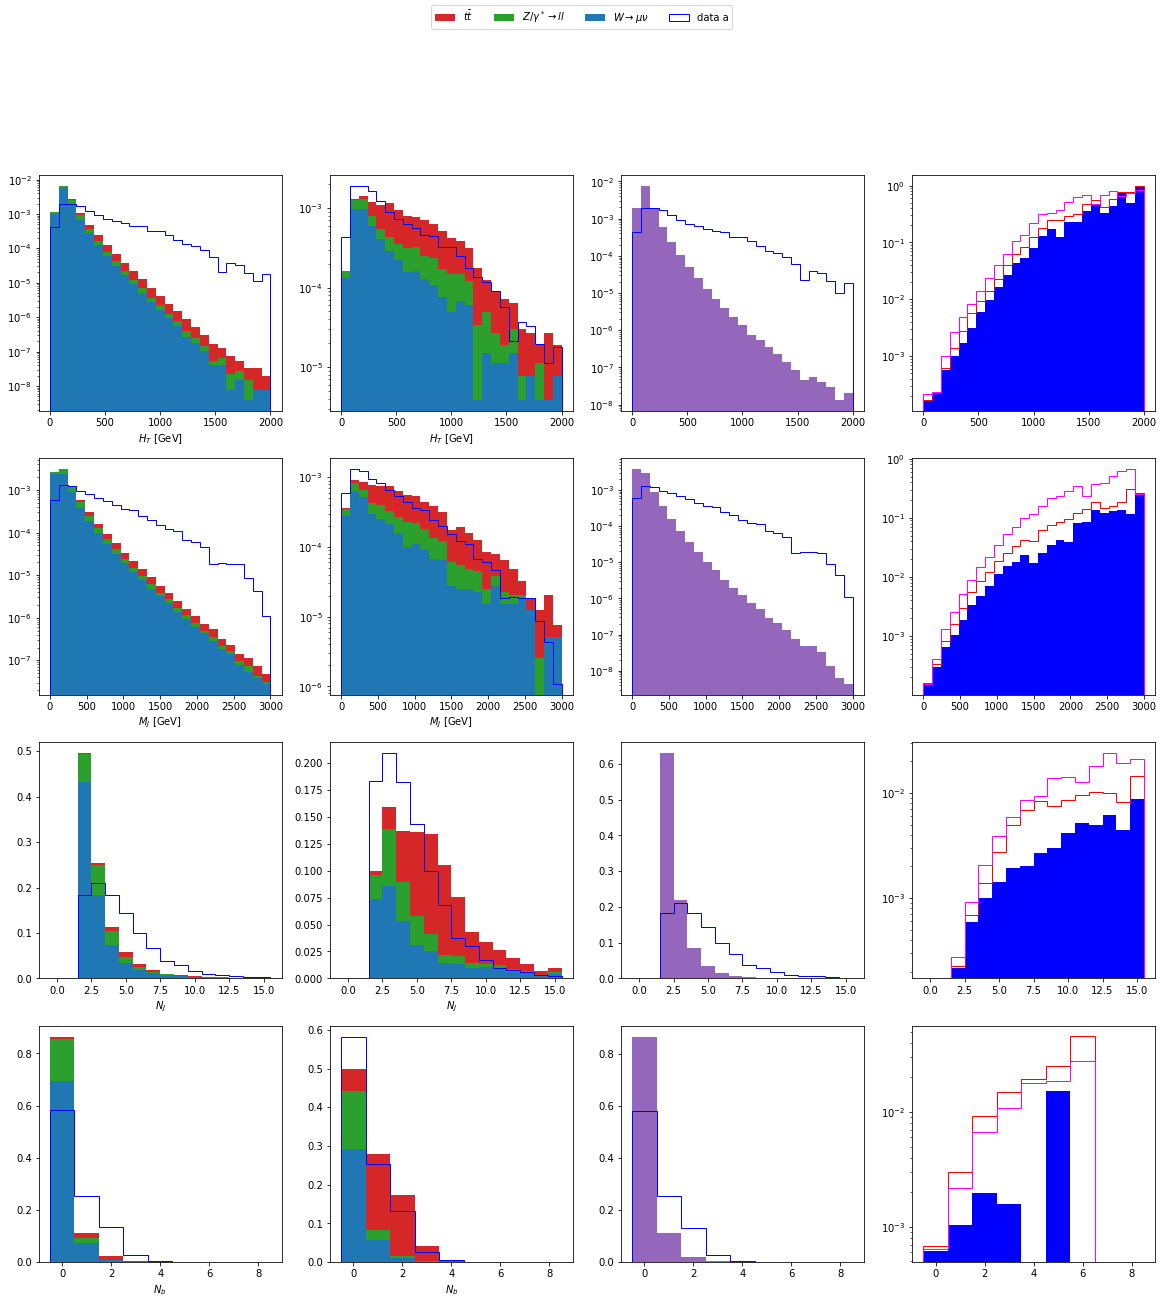

In [15]:
feature_list = ['HT', 'mass_jet', 'n_jet', 'n_bjet']
background_plot_list = ['W', 'DY', 'ttbar']

plot_size = 5

color_dict = {}
color_dict['W']='tab:blue'
color_dict['DY']='tab:green'
color_dict['ttbar']='tab:red'
color_dict['data']='tab:purple'

label_dict = {}
label_dict['W'] = r'$W \rightarrow \mu\nu$'
label_dict['DY'] = r'$Z/\gamma^* \rightarrow ll$'
label_dict['ttbar'] = r'$t\bar{t}$'

all_lin = False

n_features = len(feature_list)
fig, ax_arr = plt.subplots(n_features, 4, figsize=(4 * plot_size, n_features * plot_size))

for row, feature in enumerate(feature_list):
    f_setting = hist_settings[feature]
    
    # col 0, 1
    for col, cut in enumerate(['pre-', 'pre-ano_q_bs']):
        ax = ax_arr[row, col]
    
        # plot background stacked
        x_list = []
        bin_edges = None
        weights_list = []
        color_list = []
        label_list = []
        
        for proc in background_plot_list:
            hist = hist_cut_proc_dict[cut][proc]
            bin_edges = hist[feature].bin_edges
            x_list.append(hist[feature].bin_edges[:-1])
            weights_list.append(hist[feature].bin_content)
            color_list.append(color_dict[proc])
            label_list.append(label_dict[proc])
            
        ax.hist(x_list, bin_edges, weights=weights_list, 
                stacked=True, histtype='stepfilled', color=color_list, label=label_list, density=True)
        
        hist_data_f = hist_cut_proc_dict['pre-ano_q_bs']['data'][feature]
        bin_edges = hist_data_f.bin_edges
        bin_content = hist_data_f.bin_content
        ax.hist(bin_edges[:-1], bin_edges, weights=bin_content, histtype='step', color='b', label='data a', density=True)

        
        # axis settings
        if all_lin is False:
            ax.set_yscale(f_setting['yscale'])
            
        ax.set_xlabel(f_setting['symbol'])

    # col 2
    ax = ax_arr[row, 2]
    
    # plot data
    hist_data_f = hist_cut_proc_dict['pre-']['data'][feature]
    bin_edges = hist_data_f.bin_edges
    bin_content = hist_data_f.bin_content
    ax.hist(bin_edges[:-1], bin_edges, weights=bin_content, histtype='stepfilled', density=True,color=color_dict['data'], label='data')
    
    # plot data anomalous
    hist_data_f = hist_cut_proc_dict['pre-anoscore']['data'][feature]
    bin_edges = hist_data_f.bin_edges
    bin_content = hist_data_f.bin_content
    ax.hist(bin_edges[:-1], bin_edges, weights=bin_content, histtype='step', color='b', label='data a', density=True)

    # axis settings
    if all_lin is False:
        ax.set_yscale(f_setting['yscale'])

# fix ppm
# uncertainty (opt)

# plot ADSE
for row, feature in enumerate(feature_list):
    ax = ax_arr[row, 3]
    f_setting = hist_settings[feature]
    
    bin_edges = hist_amp_dict['b'][feature].bin_edges
    bin_content = hist_amp_dict['b'][feature].bin_content
    ax.hist(bin_edges[:-1], bin_edges, weights = bin_content, histtype='stepfilled',# density=True,
            label='b', color='blue')

    bin_edges = hist_amp_dict['bs'][feature].bin_edges
    bin_content = hist_amp_dict['bs'][feature].bin_content
    ax.hist(bin_edges[:-1], bin_edges, weights = bin_content, histtype='step',# density=True,
            label='bs', color='red')
    
    bin_edges = hist_amp_dict['data'][feature].bin_edges
    bin_content = hist_amp_dict['data'][feature].bin_content
    ax.hist(bin_edges[:-1], bin_edges, weights = bin_content, histtype='step',# density=True,
            label='data', color='magenta')

    # bin_edges = hist_amp_dict['data'][feature].bin_edges
    # bin_centers = (bin_edges[:-1]+bin_edges[1:])/2
    # bin_content = hist_amp_dict['data'][feature].bin_content
    # ax.plot(bin_centers, bin_content, 'bo', label='data')
    
    ax.set_yscale('log')

handles, labels = ax_arr[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc = 'upper center', ncol=4)
# fig.legend(handles, labels, ncol=4, bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
#         mode="expand", borderaxespad=0.)


plt.savefig('figures/adse.pdf')
plt.show()

In [19]:
fig, ax_arr = plt.subplots(1, 4, figsize=(4 * plot_size, plot_size))

cut = 'pre-anoscore-pos'
for col, feature in enumerate(feature_list):
    ax = ax_arr[col]
    
    # plot background stacked
    x_list = []
    bin_edges = None
    weights_list = []
    color_list = []
    label_list = []
    
    for proc in background_plot_list:
        hist = hist_cut_proc_dict[cut][proc]
        bin_edges = hist[feature].bin_edges
        x_list.append(hist[feature].bin_edges[:-1])
        weights_list.append(hist[feature].bin_content)
        color_list.append(color_dict[proc])
        label_list.append(label_dict[proc])
        
    ax.hist(x_list, bin_edges, weights=weights_list, 
            stacked=True, histtype='stepfilled', color=color_list, label=label_list, density=True)
    
    hist_data_f = hist_cut_proc_dict[cut]['data'][feature]
    bin_edges = hist_data_f.bin_edges
    bin_content = hist_data_f.bin_content
    ax.hist(bin_edges[:-1], bin_edges, weights=bin_content, histtype='step', color='b', label='data a', density=True)

    
    # axis settings
    if all_lin is False:
        ax.set_yscale(f_setting['yscale'])
        
    ax.set_xlabel(f_setting['symbol'])

plt.show()

NameError: name 'plot_size' is not defined

In [11]:
feature_list = ['HT', 'mass_jet', 'n_jet', 'n_bjet']
background_plot_list = ['W', 'DY', 'ttbar']

plot_size = 5

color_dict = {}
color_dict['W']='tab:blue'
color_dict['DY']='tab:green'
color_dict['ttbar']='tab:red'
color_dict['data']='tab:purple'

label_dict = {}
label_dict['W'] = r'$W \rightarrow \mu\nu$'
label_dict['DY'] = r'$Z/\gamma^* \rightarrow ll$'
label_dict['ttbar'] = r'$t\bar{t}$'

all_lin = False

n_features = len(feature_list)

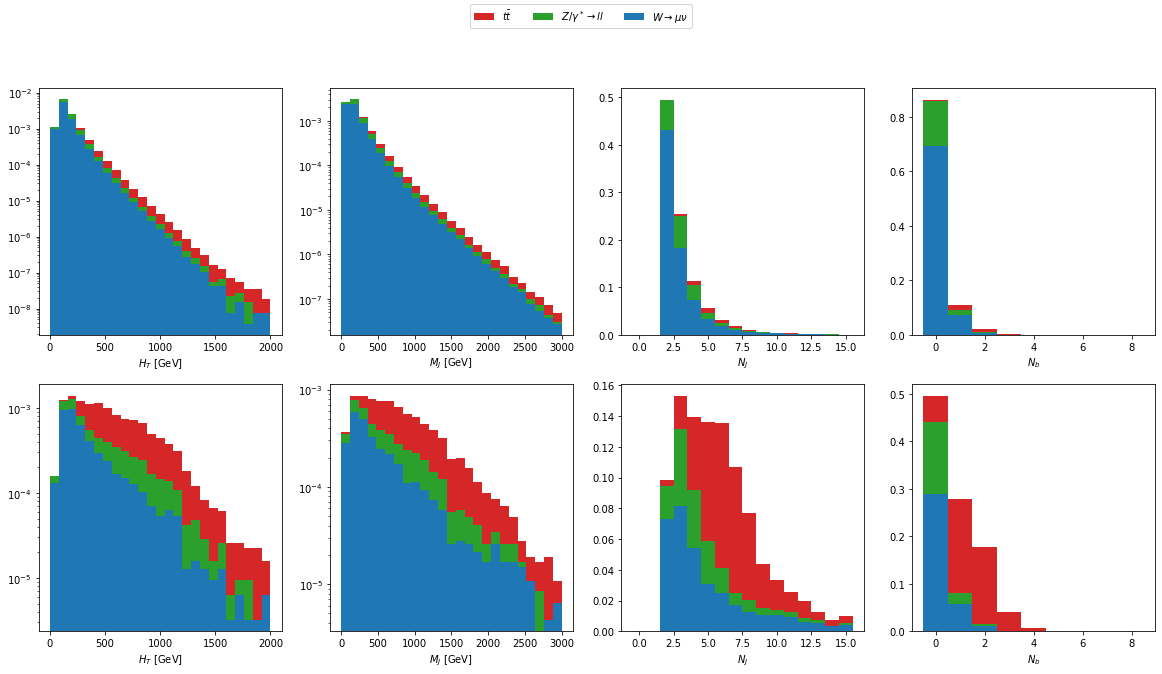

In [12]:
fig, ax_arr = plt.subplots(2, n_features, figsize=(n_features * plot_size, 2 * plot_size))

for col, feature in enumerate(feature_list):
    f_setting = hist_settings[feature]
    for row, cut in enumerate(['pre-', 'pre-anoscore']):
        ax = ax_arr[row, col]
        
        # plot background stacked
        x_list = []
        bin_edges = None
        weights_list = []
        color_list = []
        label_list = []
        for proc in background_plot_list:
            hist = hist_cut_proc_dict[cut][proc]
            bin_edges = hist[feature].bin_edges
            x_list.append(hist[feature].bin_edges[:-1])
            weights_list.append(hist[feature].bin_content)
            color_list.append(color_dict[proc])
            label_list.append(label_dict[proc])
            
        ax.hist(x_list, bin_edges, weights=weights_list, 
                stacked=True, histtype='stepfilled', color=color_list, label=label_list, density=True)
        
        # axis settings
        ax.set_xlabel(f_setting['symbol'])
        if all_lin is False:
            ax.set_yscale(f_setting['yscale'])

handles, labels = ax_arr[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc = 'upper center', ncol=4)

plt.savefig('figures/mc.pdf')
plt.show()

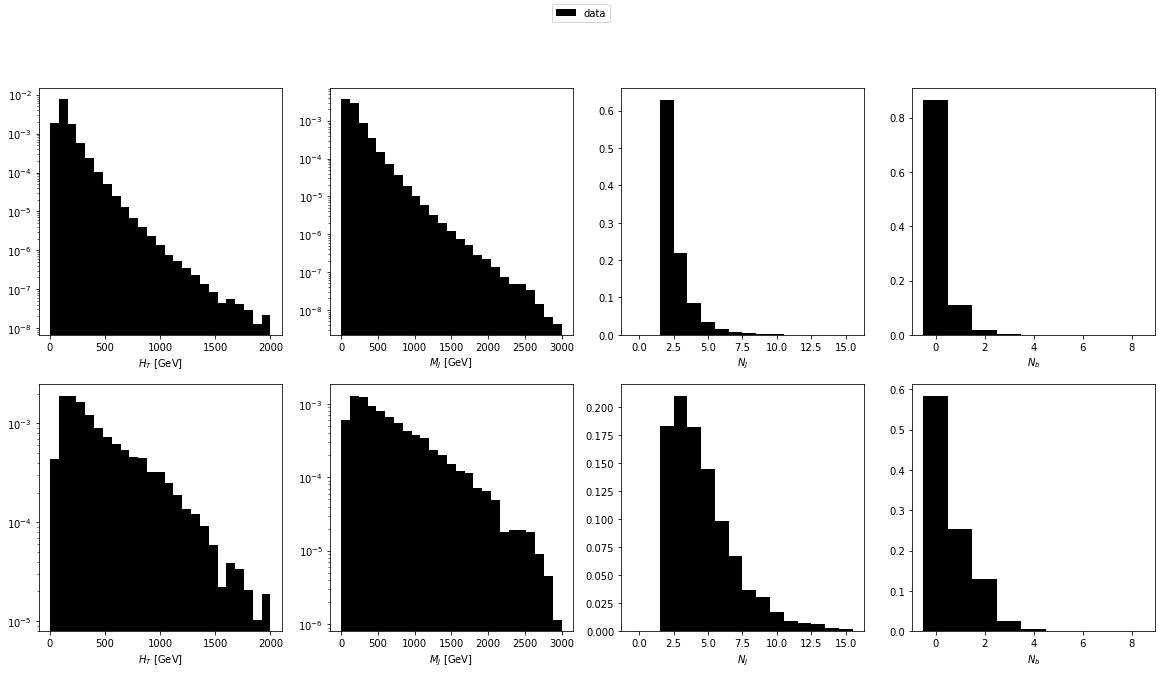

In [13]:
fig, ax_arr = plt.subplots(2, n_features, figsize=(n_features * plot_size, 2 * plot_size))

for col, feature in enumerate(feature_list):
    f_setting = hist_settings[feature]
    for row, cut in enumerate(['pre-', 'pre-anoscore']):
        ax = ax_arr[row, col]
        
        # plot data
        hist_data_f = hist_cut_proc_dict[cut]['data'][feature]
        bin_edges = hist_data_f.bin_edges
        bin_content = hist_data_f.bin_content
        ax.hist(bin_edges[:-1], bin_edges, weights=bin_content, histtype='stepfilled', color='black', label='data', density=True)
        
        # axis settings
        ax.set_xlabel(f_setting['symbol'])
        if all_lin is False:
            ax.set_yscale(f_setting['yscale'])

handles, labels = ax_arr[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc = 'upper center', ncol=1)

plt.savefig('figures/data.pdf')
plt.show()


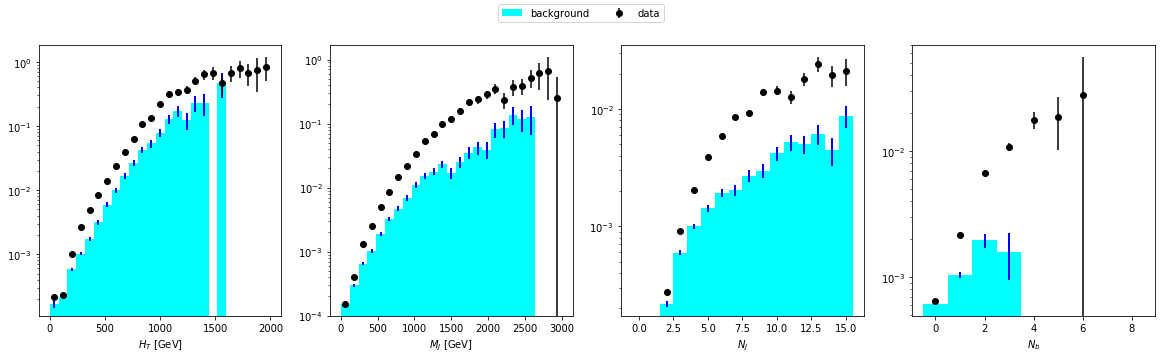

In [14]:
from uncertainties import unumpy, ufloat

fig, ax_arr = plt.subplots(1, n_features, figsize=(n_features * plot_size, 1 * plot_size))


# plot ADSE
for col, feature in enumerate(feature_list):
    ax = ax_arr[col]
    f_setting = hist_settings[feature]
    
    bin_content_pre = hist_cut_proc_dict['pre-']['b'][feature].bin_content + 1e-20
    bin_content_ano = hist_cut_proc_dict['pre-anoscore']['b'][feature].bin_content
    bin_content_pre = unumpy.uarray(bin_content_pre, np.sqrt(bin_content_pre))
    bin_content_ano = unumpy.uarray(bin_content_ano, np.sqrt(bin_content_ano))
    
    adse = bin_content_ano / bin_content_pre
    
    adse[unumpy.std_devs(adse)/(unumpy.nominal_values(adse)+1e-20)>0.5] = ufloat(0, 0)
    
    bin_edges = hist_cut_proc_dict['pre-']['data'][feature].bin_edges
    bin_centers = (bin_edges[:-1]+bin_edges[1:])/2
    
    ax.hist(bin_edges[:-1], bin_edges, weights = unumpy.nominal_values(adse), histtype='stepfilled',# density=True,
            label='background', color='cyan')

    ax.errorbar(bin_centers, unumpy.nominal_values(adse), yerr=unumpy.std_devs(adse), 
                fmt='', linestyle='', color='blue', elinewidth=2)
    
    # ax.fill_between(bin_edges[:-1], unumpy.nominal_values(adse)+unumpy.std_devs(adse), 
    #                 unumpy.nominal_values(adse)-unumpy.std_devs(adse), 
    #             alpha=1, color='grey', step='post')

    # bin_edges = hist_amp_dict['bs'][feature].bin_edges
    # bin_content = hist_amp_dict['bs'][feature].bin_content
    # ax.hist(bin_edges[:-1], bin_edges, weights = bin_content, histtype='step',# density=True,
    #         label='bs', color='red')
    
    # bin_edges = hist_amp_dict['data'][feature].bin_edges
    # bin_content = hist_amp_dict['data'][feature].bin_content
    # ax.hist(bin_edges[:-1], bin_edges, weights = bin_content, histtype='step',# density=True,
    #         label='data', color='magenta')

    
    bin_content_pre = hist_cut_proc_dict['pre-']['data'][feature].bin_content + 1e-20
    bin_content_ano = hist_cut_proc_dict['pre-anoscore']['data'][feature].bin_content
    bin_content_pre = unumpy.uarray(bin_content_pre, np.sqrt(bin_content_pre))
    bin_content_ano = unumpy.uarray(bin_content_ano, np.sqrt(bin_content_ano))
    
    adse = bin_content_ano / bin_content_pre
    
    bin_edges = hist_cut_proc_dict['pre-']['data'][feature].bin_edges
    bin_centers = (bin_edges[:-1]+bin_edges[1:])/2
    
    ax.errorbar(bin_centers, unumpy.nominal_values(adse), yerr=unumpy.std_devs(adse), 
                fmt='o', color='black', label='data')
    
    # axis settings
    ax.set_yscale('log')
    ax.set_xlabel(f_setting['symbol'])

handles, labels = ax_arr[0].get_legend_handles_labels()
fig.legend(handles, labels, loc = 'upper center', ncol=3)
# fig.legend(handles, labels, ncol=4, bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
#         mode="expand", borderaxespad=0.)

plt.savefig('figures/adse.pdf')
plt.show()

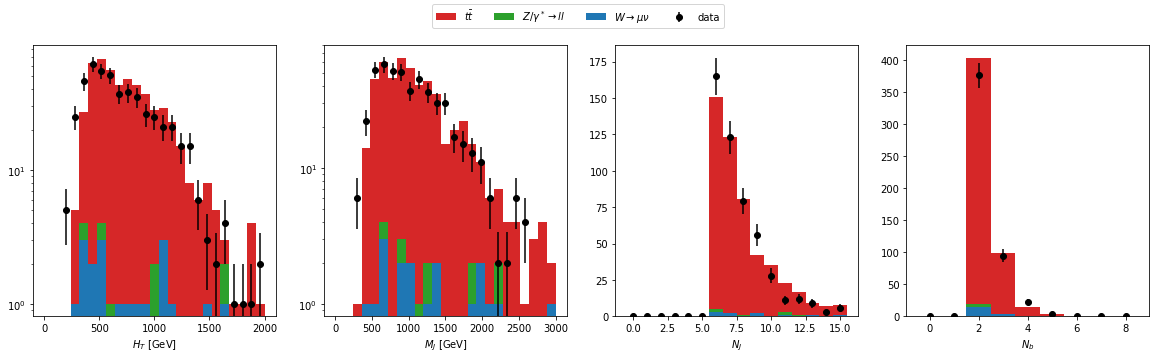

In [22]:
fig, ax_arr = plt.subplots(1, 4, figsize=(4 * plot_size, plot_size))

cut = 'pre-ano_q_bs-pos'
for col, feature in enumerate(feature_list):
    ax = ax_arr[col]
    f_setting = hist_settings[feature]
    
    # plot background stacked
    x_list = []
    bin_edges = None
    weights_list = []
    color_list = []
    label_list = []
    
    for proc in background_plot_list:
        hist = hist_cut_proc_dict[cut][proc]
        bin_edges = hist[feature].bin_edges
        x_list.append(hist[feature].bin_edges[:-1])
        weights_list.append(hist[feature].bin_content)
        color_list.append(color_dict[proc])
        label_list.append(label_dict[proc])
    
    ax.hist(x_list, bin_edges, weights=weights_list, 
            stacked=True, histtype='stepfilled', color=color_list, label=label_list)#, density=True)
    
    hist_data_f = hist_cut_proc_dict[cut]['data'][feature]
    bin_edges = hist_data_f.bin_edges
    bin_centers = (bin_edges[:-1]+bin_edges[1:])/2
    bin_content = hist_data_f.bin_content
    
    ax.errorbar(bin_centers, bin_content, yerr=np.sqrt(bin_content), 
                fmt='o', color='black', label='data')
    
    # axis settings
    if all_lin is False:
        ax.set_yscale(f_setting['yscale'])
        
    ax.set_xlabel(f_setting['symbol'])

handles, labels = ax_arr[0].get_legend_handles_labels()
fig.legend(handles, labels, loc = 'upper center', ncol=4)

plt.savefig('figures/post.pdf')
plt.show()

